In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


✅ Librerías importadas correctamente
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive montado correctamente
🚀 INICIANDO CARGA DE IMÁGENES REALES DESDE GOOGLE DRIVE
🔍 CARGANDO IMÁGENES REALES DESDE: /content/drive/MyDrive/p_image
✅ Directorio encontrado: /content/drive/MyDrive/p_image
📁 Contenido del directorio: ['malignant', 'normal', 'benign', 'Copia de 322.PNG', 'Copia de 320.PNG', 'Copia de 317.PNG', 'Copia de 318.PNG', 'Copia de 319.PNG', 'Copia de 326.PNG', 'Copia de 323.PNG', 'Copia de 321.PNG', 'Copia de 325.PNG', 'Copia de 313.PNG', 'Copia de 310.PNG', 'Copia de 314.PNG', 'Copia de 311.PNG', 'Copia de 316.PNG', 'Copia de 312.PNG', 'Copia de 315.PNG', 'Copia de 399.PNG', 'Copia de 397.PNG', 'Copia de 395.PNG', 'Copia de 396.PNG', 'Copia de 398.PNG']

📂 Procesando directorio: malignant
   📷 Encontradas 326 imágenes en malignant
      Procesadas 10/326 imágenes...
      Procesadas 20/326

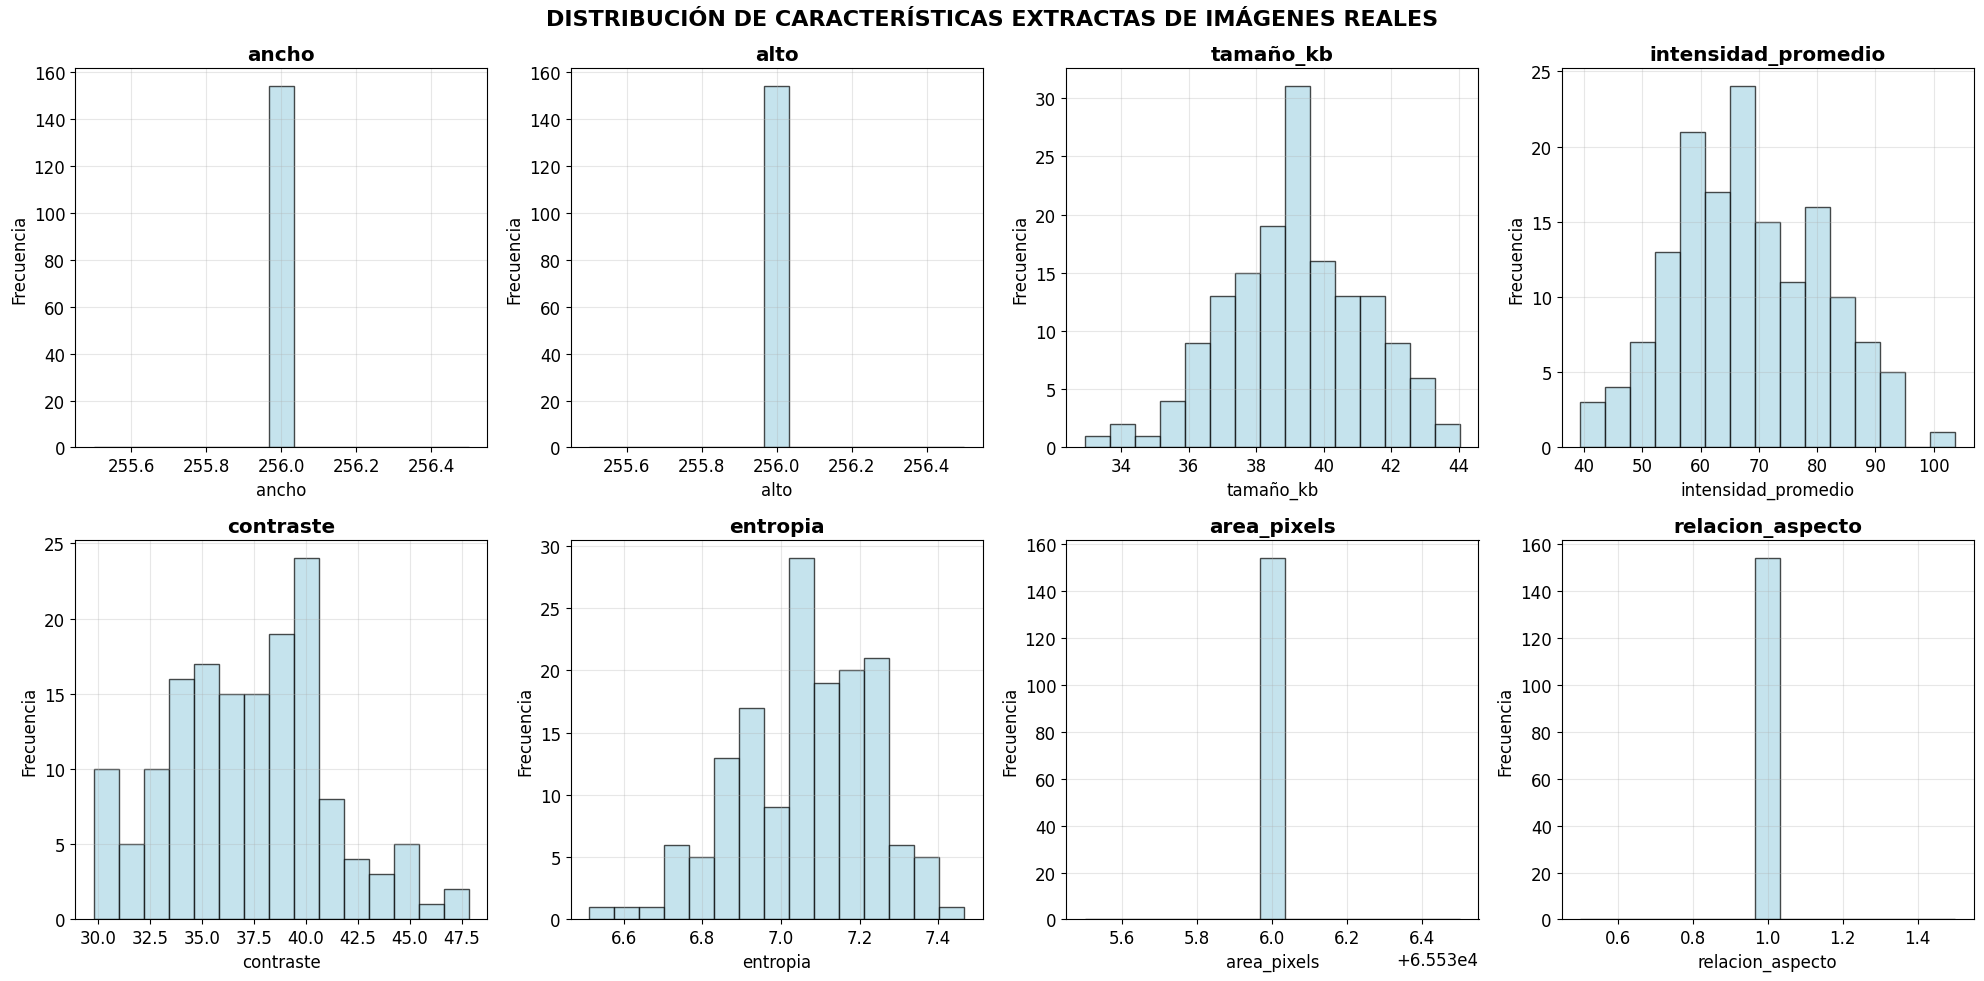


🔍 ANÁLISIS POR CLASE - CARACTERÍSTICAS REALES
---------------------------------------------


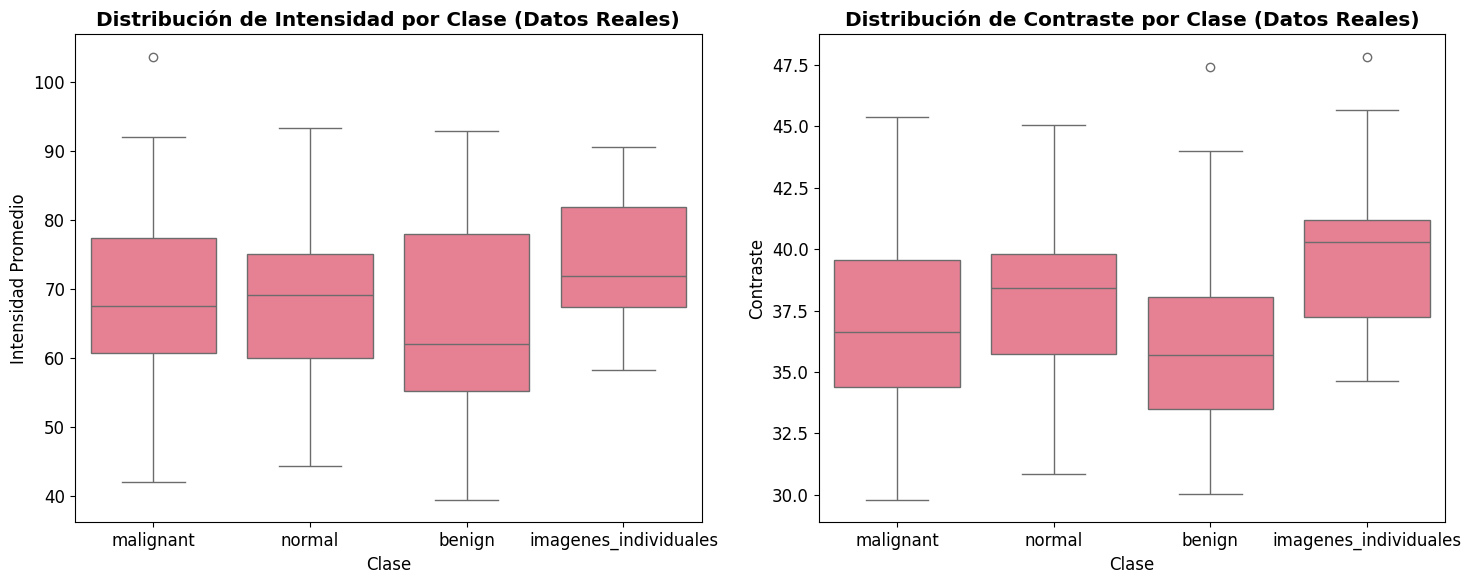


📊 MATRIZ DE CORRELACIÓN - CARACTERÍSTICAS REALES
---------------------------------------------


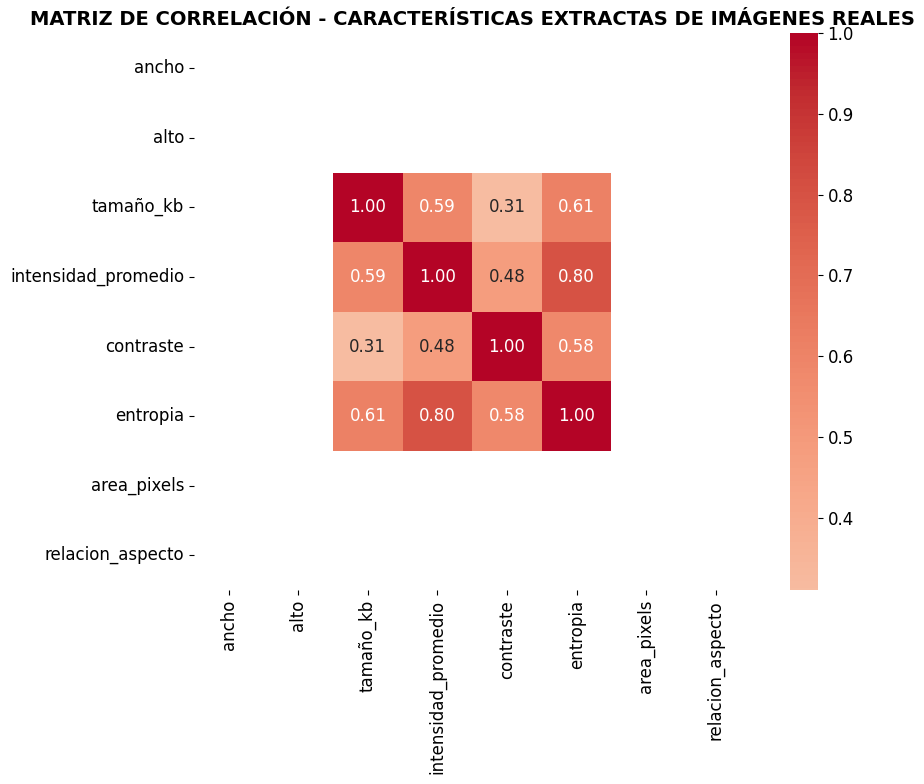


🔍 DETECCIÓN DE OUTLIERS EN DATOS REALES
----------------------------------------
Outliers detectados (Z-score > 3):
              Variable  Outliers_Z       %_Z
0                ancho           0  0.000000
1                 alto           0  0.000000
2            tamaño_kb           1  0.649351
3  intensidad_promedio           0  0.000000

CONCLUSIONES E INSIGHTS - DATOS REALES
📊 RESUMEN EJECUTIVO - IMÁGENES REALES:
• Total de imágenes analizadas: 154
• Clases identificadas: 4
• Características extraídas: 8
• Calidad general: 1 outliers totales

🎯 RECOMENDACIONES PARA MODELADO CON DATOS REALES:
• Preprocesamiento: Resizing estandarizado según dimensiones reales
• Data augmentation: Basada en la distribución real de clases
• Modelado: Transfer Learning con características reales extraídas
• Validación: Split estratificado según distribución real

💾 Dataset real guardado: 'dataset_tiroides_real.csv'

✅ ANÁLISIS COMPLETADO CON 154 IMÁGENES REALES


In [42]:
# ANÁLISIS EXPLORATORIO DE DATOS (EDA) - CLASIFICACIÓN DE NÓDULOS TIROIDEOS
# SCRIPT CORREGIDO - CARGA IMÁGENES REALES DE GOOGLE DRIVE

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
from scipy import stats
from scipy.stats import kurtosis, skew, pearsonr, shapiro, norm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualizaciones
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("✅ Librerías importadas correctamente")

# =============================================================================
# MONTAJE DE GOOGLE DRIVE Y CARGA DE IMÁGENES REALES
# =============================================================================

# Montar Google Drive (solo necesario en Google Colab)
try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("✅ Google Drive montado correctamente")
except:
    print("ℹ️  No está en Google Colab, asumiendo acceso directo al directorio")

def cargar_imagenes_reales_desde_drive(ruta_base):
    """Cargar imágenes reales desde Google Drive"""
    print(f"🔍 CARGANDO IMÁGENES REALES DESDE: {ruta_base}")
    print("=" * 60)

    if not os.path.exists(ruta_base):
        print(f"❌ ERROR: La ruta {ruta_base} no existe")
        print("💡 Verifica que Google Drive esté montado correctamente")
        return None, []

    print(f"✅ Directorio encontrado: {ruta_base}")

    metadatos = []
    clases_encontradas = set()
    total_imagenes = 0

    try:
        # Explorar la estructura del directorio
        contenido = os.listdir(ruta_base)
        print(f"📁 Contenido del directorio: {contenido}")

        # Buscar subdirectorios (clases)
        for item in contenido:
            item_path = os.path.join(ruta_base, item)

            if os.path.isdir(item_path):
                # Es un directorio (posible clase)
                print(f"\n📂 Procesando directorio: {item}")
                clase_actual = item
                clases_encontradas.add(clase_actual)

                # Contar imágenes en este directorio
                imagenes_clase = []
                for archivo in os.listdir(item_path):
                    if archivo.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.dcm')):
                        imagenes_clase.append(archivo)

                print(f"   📷 Encontradas {len(imagenes_clase)} imágenes en {clase_actual}")

                # Procesar imágenes (limitar a 50 por clase para eficiencia)
                for i, archivo in enumerate(imagenes_clase[:50]):
                    try:
                        img_path = os.path.join(item_path, archivo)

                        with Image.open(img_path) as img:
                            # Convertir a RGB si es necesario
                            if img.mode != 'RGB':
                                img = img.convert('RGB')

                            ancho, alto = img.size
                            img_array = np.array(img)

                            # Calcular características de la imagen
                            if len(img_array.shape) == 3:  # Imagen color
                                intensidad_promedio = img_array.mean()
                                contraste = img_array.std()
                                # Calcular entropía por canal y promediar
                                entropias = []
                                for channel in range(3):
                                    hist, _ = np.histogram(img_array[:,:,channel].flatten(), bins=256, density=True)
                                    hist = hist[hist > 0]  # Eliminar ceros para log
                                    entropias.append(-np.sum(hist * np.log2(hist)))
                                entropia = np.mean(entropias)
                            else:  # Imagen escala de grises
                                intensidad_promedio = img_array.mean()
                                contraste = img_array.std()
                                hist, _ = np.histogram(img_array.flatten(), bins=256, density=True)
                                hist = hist[hist > 0]
                                entropia = -np.sum(hist * np.log2(hist))

                            metadatos.append({
                                'clase': clase_actual,
                                'archivo': archivo,
                                'ruta_completa': img_path,
                                'ancho': ancho,
                                'alto': alto,
                                'modo': img.mode,
                                'tamaño_kb': os.path.getsize(img_path) / 1024,
                                'intensidad_promedio': intensidad_promedio,
                                'contraste': contraste,
                                'entropia': entropia,
                                'relacion_aspecto': ancho / alto,
                                'area_pixels': ancho * alto
                            })

                            total_imagenes += 1

                        if (i + 1) % 10 == 0:
                            print(f"      Procesadas {i + 1}/{len(imagenes_clase)} imágenes...")

                    except Exception as e:
                        print(f"⚠️  Error procesando {archivo}: {e}")

            else:
                # Es un archivo individual
                if item.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                    print(f"\n📄 Procesando archivo individual: {item}")
                    try:
                        img_path = os.path.join(ruta_base, item)

                        with Image.open(img_path) as img:
                            if img.mode != 'RGB':
                                img = img.convert('RGB')

                            ancho, alto = img.size
                            img_array = np.array(img)

                            intensidad_promedio = img_array.mean()
                            contraste = img_array.std()

                            # Calcular entropía
                            hist, _ = np.histogram(img_array.flatten(), bins=256, density=True)
                            hist = hist[hist > 0]
                            entropia = -np.sum(hist * np.log2(hist))

                            metadatos.append({
                                'clase': 'imagenes_individuales',
                                'archivo': item,
                                'ruta_completa': img_path,
                                'ancho': ancho,
                                'alto': alto,
                                'modo': img.mode,
                                'tamaño_kb': os.path.getsize(img_path) / 1024,
                                'intensidad_promedio': intensidad_promedio,
                                'contraste': contraste,
                                'entropia': entropia,
                                'relacion_aspecto': ancho / alto,
                                'area_pixels': ancho * alto
                            })

                            total_imagenes += 1
                            clases_encontradas.add('imagenes_individuales')

                    except Exception as e:
                        print(f"⚠️  Error procesando archivo individual {item}: {e}")

        print(f"\n✅ CARGA COMPLETADA: {total_imagenes} imágenes procesadas")
        print(f"🏷️  Clases encontradas: {list(clases_encontradas)}")

        if total_imagenes == 0:
            print("❌ No se encontraron imágenes válidas en el directorio")
            return None, []

        return metadatos, list(clases_encontradas)

    except Exception as e:
        print(f"❌ Error general al cargar imágenes: {e}")
        return None, []

# =============================================================================
# EJECUCIÓN PRINCIPAL - CARGA DE IMÁGENES REALES
# =============================================================================

print("🚀 INICIANDO CARGA DE IMÁGENES REALES DESDE GOOGLE DRIVE")
print("=" * 70)

# Ruta específica de Google Drive
ruta_imagenes = "/content/drive/MyDrive/p_image"

# Cargar imágenes reales
metadatos, clases = cargar_imagenes_reales_desde_drive(ruta_imagenes)

if metadatos and len(metadatos) > 0:
    # Crear DataFrame con imágenes reales
    df_metadatos = pd.DataFrame(metadatos)
    print(f"\n🎉 DATASET REAL CREADO EXITOSAMENTE")
    print(f"   • Imágenes procesadas: {len(df_metadatos)}")
    print(f"   • Clases encontradas: {clases}")
    print(f"   • Características extraídas: {len(df_metadatos.columns)}")

    # Mostrar distribución real
    distribucion_real = df_metadatos['clase'].value_counts()
    print(f"   • Distribución real:")
    for clase, count in distribucion_real.items():
        print(f"      {clase}: {count} imágenes ({(count/len(df_metadatos))*100:.1f}%)")

else:
    print("\n❌ No se pudieron cargar imágenes reales. Verifica la ruta y los permisos.")
    print("💡 Asegúrate de que:")
    print("   - Google Drive esté montado correctamente")
    print("   - La ruta '/content/drive/MyDrive/p_image' exista")
    print("   - El directorio contenga imágenes en formatos válidos")
    exit()

# =============================================================================
# ANÁLISIS EXPLORATORIO CON DATOS REALES
# =============================================================================

# Variables para análisis (basadas en características reales extraídas)
variables_numericas = ['ancho', 'alto', 'tamaño_kb', 'intensidad_promedio',
                      'contraste', 'entropia', 'area_pixels', 'relacion_aspecto']

print("\n" + "="*80)
print("ANÁLISIS EXPLORATORIO CON IMÁGENES REALES")
print("="*80)

# 1. INFORMACIÓN GENERAL DEL DATASET REAL
print("📋 INFORMACIÓN GENERAL DEL DATASET REAL")
print("-" * 50)

print(f"📊 Total de imágenes: {len(df_metadatos)}")
print(f"🏷️  Clases: {df_metadatos['clase'].unique().tolist()}")
print(f"📈 Distribución por clase:")
distribucion = df_metadatos['clase'].value_counts()
for clase, count in distribucion.items():
    porcentaje = (count / len(df_metadatos)) * 100
    print(f"   • {clase}: {count} imágenes ({porcentaje:.1f}%)")

print(f"\n🔍 Calidad de datos:")
print(f"   Valores faltantes: {df_metadatos.isnull().sum().sum()}")
print(f"   Tipos de datos:")
print(df_metadatos.dtypes.value_counts())

# 2. ESTADÍSTICAS DESCRIPTIVAS DE CARACTERÍSTICAS REALES
print(f"\n📊 ESTADÍSTICAS DESCRIPTIVAS (DATOS REALES)")
print("-" * 45)

stats_reales = df_metadatos[variables_numericas].describe().round(2)
print(stats_reales)

# 3. VISUALIZACIÓN DE CARACTERÍSTICAS REALES
print("\n" + "="*80)
print("VISUALIZACIÓN DE CARACTERÍSTICAS EXTRACTAS DE IMÁGENES REALES")
print("="*80)

# Histogramas de características reales
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('DISTRIBUCIÓN DE CARACTERÍSTICAS EXTRACTAS DE IMÁGENES REALES',
             fontsize=16, fontweight='bold')

for i, variable in enumerate(variables_numericas):
    row, col = i // 4, i % 4
    if row < 2:  # Asegurar que no exceda los subplots
        axes[row, col].hist(df_metadatos[variable], bins=15, alpha=0.7,
                           color='lightblue', edgecolor='black')
        axes[row, col].set_title(f'{variable}', fontweight='bold')
        axes[row, col].set_xlabel(variable)
        axes[row, col].set_ylabel('Frecuencia')
        axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 4. ANÁLISIS POR CLASE CON DATOS REALES
print("\n🔍 ANÁLISIS POR CLASE - CARACTERÍSTICAS REALES")
print("-" * 45)

# Boxplots de intensidad y contraste por clase
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Intensidad por clase
sns.boxplot(data=df_metadatos, x='clase', y='intensidad_promedio', ax=axes[0])
axes[0].set_title('Distribución de Intensidad por Clase (Datos Reales)', fontweight='bold')
axes[0].set_xlabel('Clase')
axes[0].set_ylabel('Intensidad Promedio')

# Contraste por clase
sns.boxplot(data=df_metadatos, x='clase', y='contraste', ax=axes[1])
axes[1].set_title('Distribución de Contraste por Clase (Datos Reales)', fontweight='bold')
axes[1].set_xlabel('Clase')
axes[1].set_ylabel('Contraste')

plt.tight_layout()
plt.show()

# 5. MATRIZ DE CORRELACIÓN DE CARACTERÍSTICAS REALES
print("\n📊 MATRIZ DE CORRELACIÓN - CARACTERÍSTICAS REALES")
print("-" * 45)

corr_matrix_real = df_metadatos[variables_numericas].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_real, annot=True, cmap='coolwarm', center=0,
            fmt='.2f', square=True)
plt.title('MATRIZ DE CORRELACIÓN - CARACTERÍSTICAS EXTRACTAS DE IMÁGENES REALES',
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# 6. ANÁLISIS DE OUTLIERS EN DATOS REALES
print("\n🔍 DETECCIÓN DE OUTLIERS EN DATOS REALES")
print("-" * 40)

outliers_info_real = []
for variable in variables_numericas[:4]:  # Analizar primeras 4 variables
    z_scores = np.abs(stats.zscore(df_metadatos[variable]))
    outliers = len(df_metadatos[z_scores > 3])
    outliers_info_real.append({
        'Variable': variable,
        'Outliers_Z': outliers,
        '%_Z': (outliers/len(df_metadatos))*100
    })

outliers_df_real = pd.DataFrame(outliers_info_real)
print("Outliers detectados (Z-score > 3):")
print(outliers_df_real)

# 7. CONCLUSIONES CON DATOS REALES
print("\n" + "="*80)
print("CONCLUSIONES E INSIGHTS - DATOS REALES")
print("="*80)

print("📊 RESUMEN EJECUTIVO - IMÁGENES REALES:")
print(f"• Total de imágenes analizadas: {len(df_metadatos)}")
print(f"• Clases identificadas: {len(clases)}")
print(f"• Características extraídas: {len(variables_numericas)}")
print(f"• Calidad general: {outliers_df_real['Outliers_Z'].sum()} outliers totales")

print(f"\n🎯 RECOMENDACIONES PARA MODELADO CON DATOS REALES:")
print("• Preprocesamiento: Resizing estandarizado según dimensiones reales")
print("• Data augmentation: Basada en la distribución real de clases")
print("• Modelado: Transfer Learning con características reales extraídas")
print("• Validación: Split estratificado según distribución real")

# Guardar resultados con datos reales
df_metadatos.to_csv('dataset_tiroides_real.csv', index=False)
print(f"\n💾 Dataset real guardado: 'dataset_tiroides_real.csv'")

print(f"\n✅ ANÁLISIS COMPLETADO CON {len(df_metadatos)} IMÁGENES REALES")

✅ Imágenes cargadas: 724
clase
benign       365
malignant    326
normal        33
Name: count, dtype: int64

📋 INFORMACIÓN GENERAL
📊 Dimensiones: 724 filas × 11 columnas
🏷️ Clases: {'benign': 365, 'malignant': 326, 'normal': 33}
❌ Valores faltantes: 0
❌ Duplicados: 0

🔍 Primeras 5 filas del dataset:
       clase    archivo  ancho  alto modo  tamaño_kb  intensidad_promedio  \
0  malignant  10131.PNG    256   256    L      37.18                62.01   
1  malignant  10110.PNG    256   256    L      38.59                63.30   
2  malignant  10114.PNG    256   256    L      38.86                60.93   
3  malignant  10117.PNG    256   256    L      38.51                63.30   
4  malignant  10098.PNG    256   256    L      38.93                81.78   

   contraste  entropia  relacion_aspecto  area_pixels  
0      35.08      4.71               1.0        65536  
1      30.21      4.77               1.0        65536  
2      35.97      4.89               1.0        65536  
3      32.85

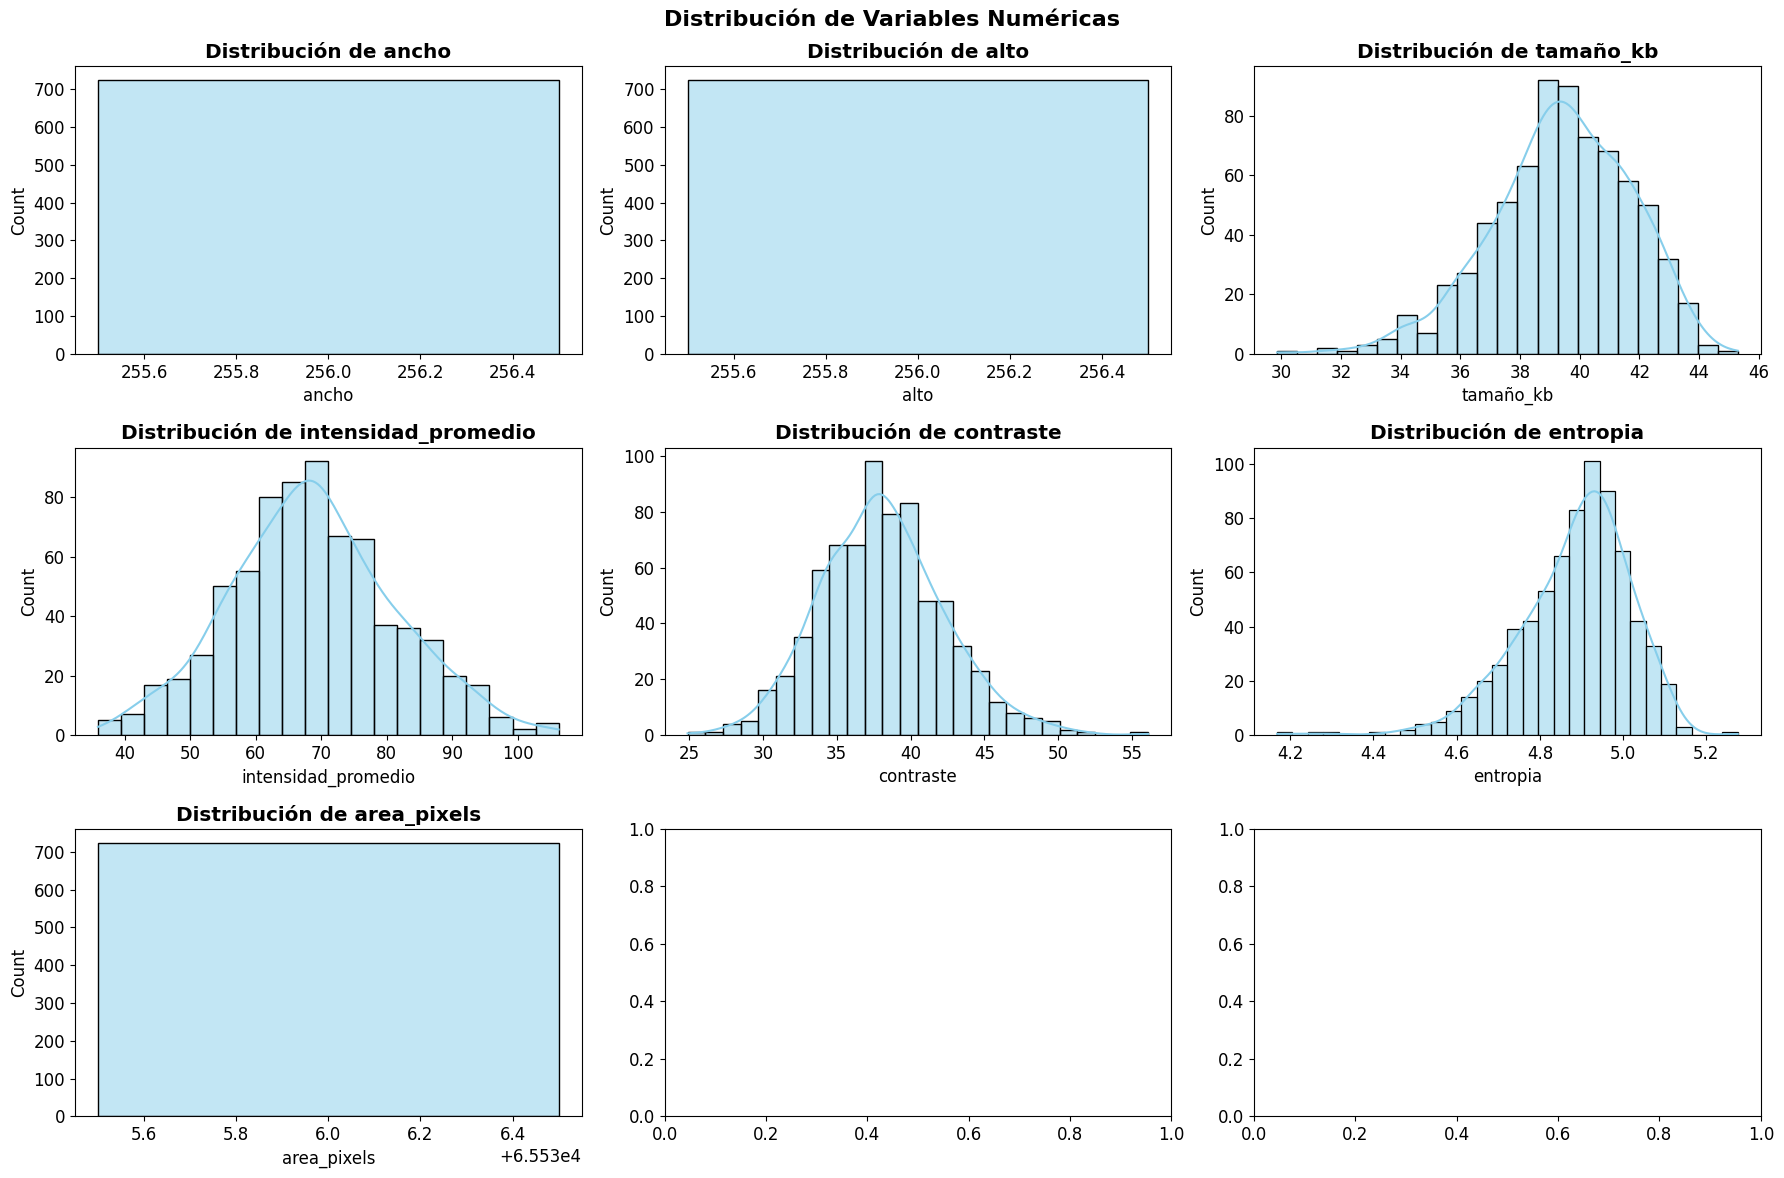

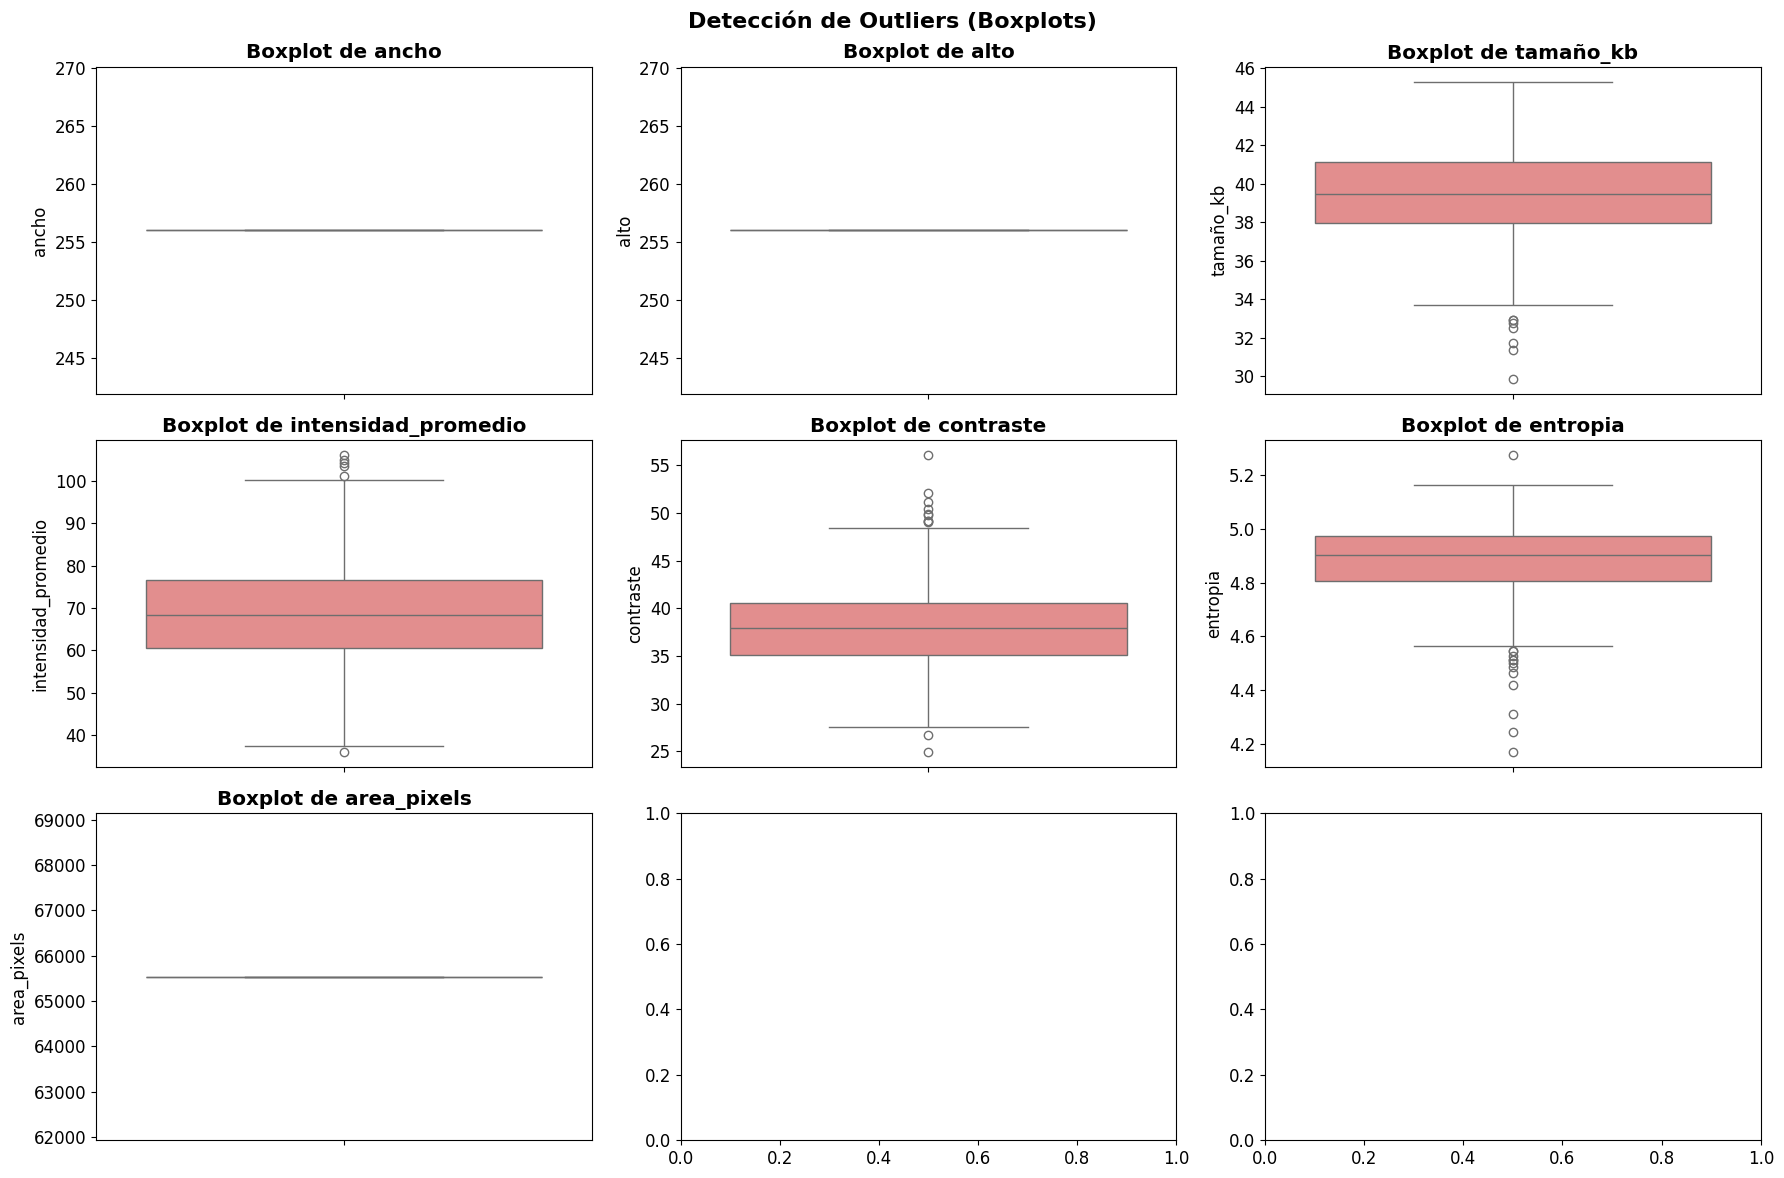


🔗 ANÁLISIS BIVARIADO


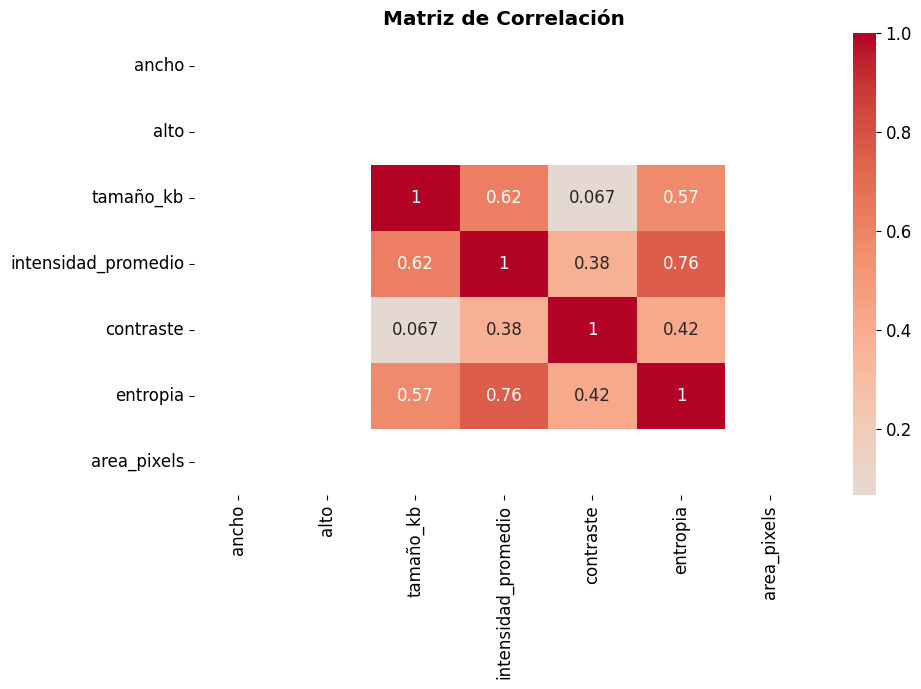


📊 Correlaciones significativas:
   • tamaño_kb ↔ intensidad_promedio: r=0.618, p=0.0000
   • tamaño_kb ↔ entropia: r=0.571, p=0.0000
   • intensidad_promedio ↔ contraste: r=0.379, p=0.0000
   • intensidad_promedio ↔ entropia: r=0.759, p=0.0000
   • contraste ↔ entropia: r=0.423, p=0.0000

🚨 DETECCIÓN DE ANOMALÍAS
              Variable  Outliers (>3σ) Porcentaje
0                ancho               0       0.0%
1                 alto               0       0.0%
2            tamaño_kb               3       0.4%
3  intensidad_promedio               0       0.0%
4            contraste               4       0.6%
5             entropia               5       0.7%
6          area_pixels               0       0.0%

📌 CONCLUSIONES E INSIGHTS
• Total de imágenes analizadas: 724
• Distribución de clases: {'benign': 365, 'malignant': 326, 'normal': 33}
• Balance ratio (desbalance entre clases): 11.06:1
• Total de outliers detectados: 12

🎯 RECOMENDACIONES
• Estandarizar tamaño de imágenes (ej. 224

In [43]:
# =============================================================================
# ANÁLISIS EXPLORATORIO DE IMÁGENES DE TIROIDES (EDA COMPLETO)
# =============================================================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from scipy import stats
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings("ignore")

# Configuración visual
plt.style.use("default")
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.size"] = 12

# -----------------------------------------------------------------------------
# 1. CARGA DEL DATASET DESDE GOOGLE DRIVE
# -----------------------------------------------------------------------------
base_path = r"/content/drive/MyDrive/p_image"
clases = ["malignant", "benign", "normal"]

def extraer_metadatos_img(img_path, clase):
    try:
        with Image.open(img_path) as img:
            ancho, alto = img.size
            modo = img.mode
            array = np.array(img.convert("L"))  # escala de grises para features
            intensidad = np.mean(array)
            contraste = np.std(array)
            entropia = stats.entropy(np.histogram(array, bins=256)[0] + 1)

        return {
            "clase": clase,
            "archivo": os.path.basename(img_path),
            "ancho": ancho,
            "alto": alto,
            "modo": modo,
            "tamaño_kb": os.path.getsize(img_path) / 1024,
            "intensidad_promedio": intensidad,
            "contraste": contraste,
            "entropia": entropia,
            "relacion_aspecto": ancho / alto if alto > 0 else np.nan,
            "area_pixels": ancho * alto
        }
    except Exception as e:
        print(f"⚠️ Error con {img_path}: {e}")
        return None

# Recorremos carpetas y generamos DataFrame
metadatos = []
for clase in clases:
    carpeta = os.path.join(base_path, clase)
    if not os.path.exists(carpeta):
        print(f"⚠️ Carpeta no encontrada: {carpeta}")
        continue
    for archivo in os.listdir(carpeta):
        if archivo.lower().endswith((".png", ".jpg", ".jpeg")):
            ruta = os.path.join(carpeta, archivo)
            meta = extraer_metadatos_img(ruta, clase)
            if meta:
                metadatos.append(meta)

df_metadatos = pd.DataFrame(metadatos)
print("✅ Imágenes cargadas:", len(df_metadatos))
print(df_metadatos["clase"].value_counts())

# -----------------------------------------------------------------------------
# 2. INFORMACIÓN GENERAL DEL DATASET
# -----------------------------------------------------------------------------
print("\n📋 INFORMACIÓN GENERAL")
print(f"📊 Dimensiones: {df_metadatos.shape[0]} filas × {df_metadatos.shape[1]} columnas")
print(f"🏷️ Clases: {df_metadatos['clase'].value_counts().to_dict()}")
print(f"❌ Valores faltantes: {df_metadatos.isnull().sum().sum()}")
print(f"❌ Duplicados: {df_metadatos.duplicated().sum()}")

print("\n🔍 Primeras 5 filas del dataset:")
print(df_metadatos.head().round(2))

# -----------------------------------------------------------------------------
# 3. DISTRIBUCIÓN DE VARIABLES NUMÉRICAS
# -----------------------------------------------------------------------------
variables = [
    "ancho", "alto", "tamaño_kb",
    "intensidad_promedio", "contraste", "entropia", "area_pixels"
]

fig, axes = plt.subplots(3, 3, figsize=(18, 12))
fig.suptitle("Distribución de Variables Numéricas", fontsize=16, fontweight="bold")

for i, variable in enumerate(variables):
    row, col = divmod(i, 3)
    sns.histplot(df_metadatos[variable], kde=True, ax=axes[row, col], color="skyblue")
    axes[row, col].set_title(f"Distribución de {variable}", fontweight="bold")

plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# 4. DETECCIÓN DE OUTLIERS - BOXPLOTS
# -----------------------------------------------------------------------------
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
fig.suptitle("Detección de Outliers (Boxplots)", fontsize=16, fontweight="bold")

for i, variable in enumerate(variables):
    row, col = divmod(i, 3)
    sns.boxplot(y=df_metadatos[variable], ax=axes[row, col], color="lightcoral")
    axes[row, col].set_title(f"Boxplot de {variable}", fontweight="bold")

plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# 5. ANÁLISIS BIVARIADO Y CORRELACIÓN
# -----------------------------------------------------------------------------
print("\n🔗 ANÁLISIS BIVARIADO")
corr_matrix = df_metadatos[variables].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Matriz de Correlación", fontweight="bold")
plt.show()

print("\n📊 Correlaciones significativas:")
for i, v1 in enumerate(variables):
    for j, v2 in enumerate(variables):
        if i < j:
            corr, p_val = pearsonr(df_metadatos[v1], df_metadatos[v2])
            if p_val < 0.05 and abs(corr) > 0.2:
                print(f"   • {v1} ↔ {v2}: r={corr:.3f}, p={p_val:.4f}")

# -----------------------------------------------------------------------------
# 6. DETECCIÓN DE ANOMALÍAS (Z-score)
# -----------------------------------------------------------------------------
print("\n🚨 DETECCIÓN DE ANOMALÍAS")
outliers_info = []
for variable in variables:
    z_scores = np.abs(stats.zscore(df_metadatos[variable]))
    outliers = len(df_metadatos[z_scores > 3])
    outliers_info.append({
        "Variable": variable,
        "Outliers (>3σ)": outliers,
        "Porcentaje": f"{(outliers / len(df_metadatos) * 100):.1f}%"
    })

outliers_df = pd.DataFrame(outliers_info)
print(outliers_df)

# -----------------------------------------------------------------------------
# 7. CONCLUSIONES E INSIGHTS
# -----------------------------------------------------------------------------
print("\n📌 CONCLUSIONES E INSIGHTS")
distribucion = df_metadatos["clase"].value_counts()
balance_ratio = distribucion.max() / distribucion.min()

print(f"• Total de imágenes analizadas: {len(df_metadatos)}")
print(f"• Distribución de clases: {distribucion.to_dict()}")
print(f"• Balance ratio (desbalance entre clases): {balance_ratio:.2f}:1")
print(f"• Total de outliers detectados: {outliers_df['Outliers (>3σ)'].sum()}")

# -----------------------------------------------------------------------------
# 8. RECOMENDACIONES
# -----------------------------------------------------------------------------
print("\n🎯 RECOMENDACIONES")
print("• Estandarizar tamaño de imágenes (ej. 224×224 px).")
print("• Aplicar data augmentation para balancear clases (rotación, flips, contraste).")
print("• Usar técnicas de normalización de intensidad.")
print("• Emplear transfer learning con modelos pre-entrenados (ResNet, EfficientNet).")
print("• Validación cruzada estratificada para mantener proporción de clases.")
print("• Monitorear y tratar outliers extremos que podrían sesgar el entrenamiento.")

print("\n✅ Análisis EDA completado con éxito.")
